# How Reddit Sentiment Affects Cryptocurrency Price

This notebook analyses the extent social media sentiment has on the price of Bitcoin. By utilizing the data we mined in the previous notebook, we can now evaluate the sentiment of the CryptoCurrency subreddit at a given day. 

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import pickle
import numpy as np
import pandas_datareader as web
import datetime as dt
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
# Import reddit post data from previous notebook
with open('data/submission_data.pickle', 'rb') as f:
    daily_threads = pickle.load(f)

Sentiment Analysis is a NLP technique used to evaluate the polarity of a given text to view if it is seen as 'positive' or 'negative'. For example, words such as 'good' and 'happy' are regarded as positive words and if present in a sentence; it will increase the polarity of said sentence. On the contrary, negative words such as 'terrible' and 'sad' would reduce the polarity of the sentence. For our needs, we will take the titles of Reddit posts (e.g. "Bitcoin falls 7%") and calculate its sentiment (negative).



In [21]:
# Example
text = "I hate Mondays."
sia = SIA()
sentiment = sia.polarity_scores(text)
print(sentiment)


{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}


In this example we can see that "I hate Mondays" has a .79 negative score, which indicates that it is a negative sentence. A more clearer way - and the one we will be using - to see that if a sentence is negative or positive is to use its compound, as seen above. That is, the positive, neutral and negative scores are combined and normalized between -1 and 1. Where a score of -1 would indicate the text is extremely negative, and vice versa.

## Updating Sentiment Analysis for Reddit
The sentiment analysis module we will be using (Vader) already has a dictionary of positive and negative words, and thus can be used out-of-the-box. However, the lexicon used on the CryptoCurrency subreddit is different from what is used in a more general setting. Synonymous words that have one meaning could mean something else in a different context. For example, 'bulls' and 'bears' are neutral words and have neutral sentiment in a general setting. However, in finance, 'bulls' refers to a 'bull market' and has a positive connotation, while 'bears' refers to a 'bear market' and has a negative connotation. For our sentiment analysis to be as accurate as possible, we need to incorporate the language used on CryptoCurrency into our sentiment dictionary. 

In [22]:
# Dictionary of words typically used on finance subreddits and its general sentiment
new_words = {
    'lambo': 4.0,
    'rekt': -4.0,
    'citron': -4.0,
    'hidenburg': -4.0,
    'moon': 4.0,
    'Elon': 2.0,
    'hodl': 2.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,
    'put': -4.0,
    'puts': -4.0,
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'fomo': 2.0,
    'paper': -1.7,
    'bullish': 3.7,
    'bearish': -3.7,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 2.9,
    'bear': -2.9,
    'pumping': 1.0,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,
    'maintain': 1.0,
    'pump': 1.9,
    'hot': 2,
    'drop': -2.5,
    'rebound': 1.5,
    'crack': 2.5, }

sia.lexicon.update(new_words)

In [23]:
# Calculate sentiment of CryptoCurrency by day
day_sentiment = np.zeros(len(daily_threads))
for i in range(len(daily_threads)):

    if daily_threads[i] is None:
        day_sentiment[i] = np.nan 
        continue

    posts = daily_threads[i]

    for _,post in posts.iterrows():
        day_sentiment[i] += sia.polarity_scores(post["title"])["compound"]
        


## Importing Bitcoin Data

In [24]:
# Get prices from 2021
start = dt.datetime(2021,1,2)
end = dt.datetime(2021,12,31)


btc = web.DataReader('BTC-USD', 'yahoo', start, end)
btc.drop(columns = ['High', 'Low', 'Open', 'Close', 'Volume'], inplace = True)
btc.rename(columns={'Adj Close': 'BTC Price'}, inplace = True)
btc.head()

,BTC Price
Date,
2021-01-01,29374.152344
2021-01-02,32127.267578
2021-01-03,32782.023438
2021-01-04,31971.914062
2021-01-05,33992.429688


In [25]:

# Append reddit daily sentiment to BTC dataframe
btc["sentiment"] = day_sentiment
btc["sentiment"].fillna(method="bfill",inplace=True)

btc.head()

,BTC Price,sentiment
Date,,
2021-01-01,29374.152344,43.5176
2021-01-02,32127.267578,59.0575
2021-01-03,32782.023438,101.4416
2021-01-04,31971.914062,99.1509
2021-01-05,33992.429688,86.2450


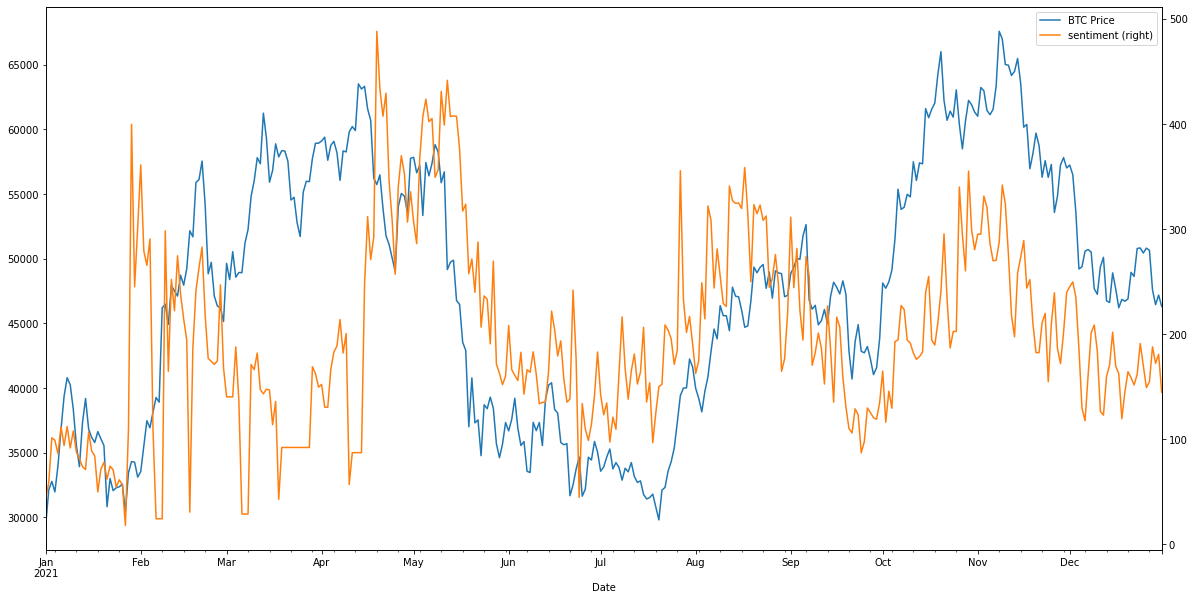

In [26]:
btc[['BTC Price',"sentiment"]].plot(secondary_y = "sentiment",figsize=(20, 10));

Although we can see semblance of a pattern, there is still a lot of noise present in the sentiment data. We will use the Fourier Transform to denoise the data. Here, we transform the sentiment data into the frequency domain. Then, we find a threshold to remove the high and low frequencies that are causing the noise. Finally, we revert back to the time domain.

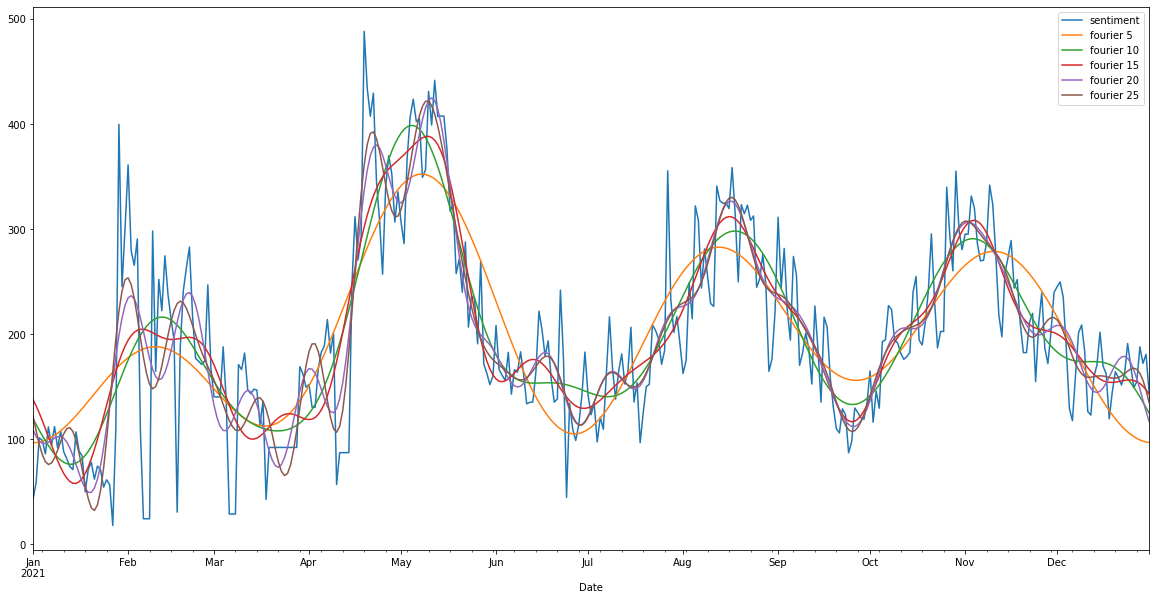

In [28]:
price_fourier = np.fft.fft(np.asarray(btc["sentiment"].tolist()))
for num_ in range(5,30,5): # create fourier columns with scores 20 and 25
    fourier_list_m10= np.copy(fourier_list); fourier_list_m10[num_:-num_]=0 
    # transform back into time spectrum append each fourier to dataframe with name of fourier
    btc['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10)
    
    # Sentiment is currently represented as a complex number, we need to get the real part for plotting.
    btc['fourier ' + str(num_)]=btc['fourier ' + str(num_)].apply(lambda x: np.real(x))
    
btc[["sentiment","fourier 5","fourier 10","fourier 15","fourier 20","fourier 25",]].plot(figsize=(20, 10));

From a visual inspection; fourier 25 seems to best represent the sentiment

In [29]:
# Copy smoothed sentiment to sentiment column
btc["sentiment"] = btc["fourier 25"]
btc.drop(columns = ["fourier 5","fourier 10","fourier 15","fourier 20","fourier 25"], inplace= True)
btc.head()

,BTC Price,sentiment
Date,,
2021-01-01,29374.152344,121.824517
2021-01-02,32127.267578,108.253947
2021-01-03,32782.023438,95.736730
2021-01-04,31971.914062,85.575643
2021-01-05,33992.429688,78.823162


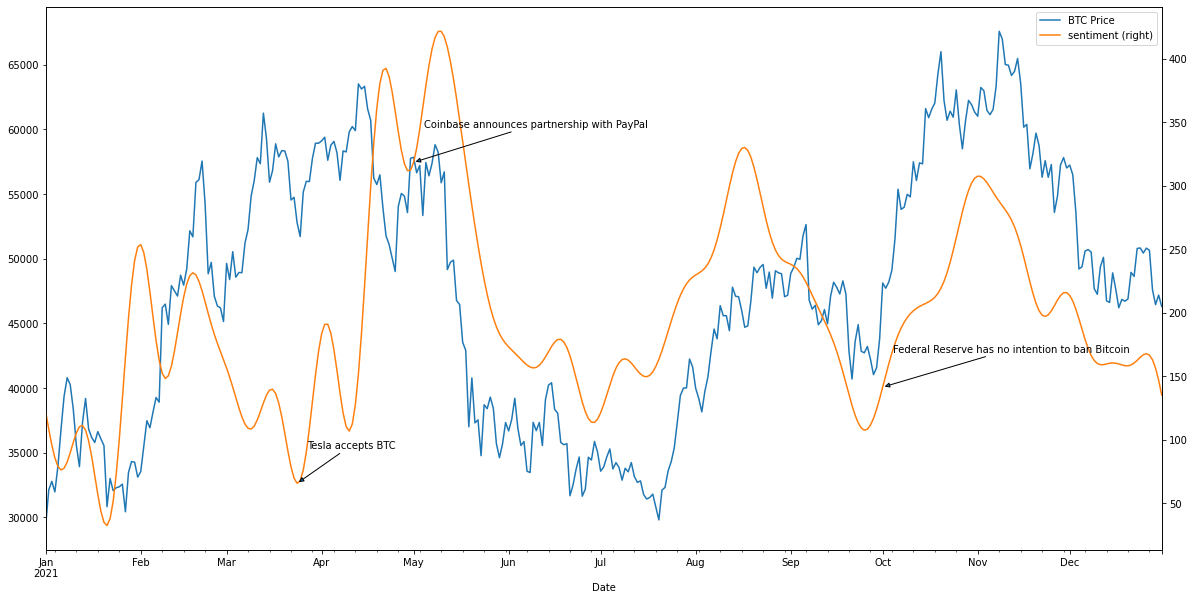

In [30]:
# btc[['BTC Price',  'fourier 25']].plot(secondary_y="fourier 25",figsize=(20, 10));
btc[['BTC Price',"sentiment"]].plot(secondary_y="sentiment",figsize=(20, 10));

plt.annotate("Tesla accepts BTC",("2021-03-24",btc.loc["2021-03-24", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.annotate("Coinbase announces partnership with PayPal",("2021-05-01",btc.loc["2021-05-01", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.annotate("Federal Reserve has no intention to ban Bitcoin",("2021-10-01",btc.loc["2021-10-01", : ]["sentiment"]),xytext=(10, 35),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

plt.show()


We can see at the end of a downtrend, the sentiment of Bitcoin reverses positively before it is reflected in its price. Perhaps we can use social media sentiment to predict a reversal from a downtrend.